# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Setup PyTorch
All files are stored at /content/csc421/a4/ folder


In [ ]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install imageio

!pip install matplotlib

%mkdir -p /content/csc413/a4/
%cd /content/csc413/a4

/content/csc413/a4


# Helper code

## Utility functions

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from six.moves.urllib.request import urlretrieve
import tarfile

import imageio
from urllib.error import URLError
from urllib.error import HTTPError


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)

    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    return fpath


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

                
def to_var(tensor, cuda=True):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

    
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()


def create_dir(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def gan_checkpoint(iteration, G, D, opts):
    """Saves the parameters of the generator G and discriminator D.
    """
    G_path = os.path.join(opts.checkpoint_dir, 'G.pkl')
    D_path = os.path.join(opts.checkpoint_dir, 'D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def load_checkpoint(opts):
    """Loads the generator and discriminator models from checkpoints.
    """
    G_path = os.path.join(opts.load, 'G.pkl')
    D_path = os.path.join(opts.load, 'D_.pkl')

    G = DCGenerator(noise_size=opts.noise_size, conv_dim=opts.g_conv_dim, spectral_norm=opts.spectral_norm)
    D = DCDiscriminator(conv_dim=opts.d_conv_dim)

    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    if torch.cuda.is_available():
        G.cuda()
        D.cuda()
        print('Models moved to GPU.')

    return G, D


def merge_images(sources, targets, opts):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(opts.batch_size))
    merged = np.zeros([3, row * h, row * w * 2])
    for (idx, s, t) in (zip(range(row ** 2), sources, targets, )):
        i = idx // row
        j = idx % row
        merged[:, i * h:(i + 1) * h, (j * 2) * h:(j * 2 + 1) * h] = s
        merged[:, i * h:(i + 1) * h, (j * 2 + 1) * h:(j * 2 + 2) * h] = t
    return merged.transpose(1, 2, 0)


def generate_gif(directory_path, keyword=None):
    images = []
    for filename in sorted(os.listdir(directory_path)):
        if filename.endswith(".png") and (keyword is None or keyword in filename):
            img_path = os.path.join(directory_path, filename)
            print("adding image {}".format(img_path))
            images.append(imageio.imread(img_path))

    if keyword:
        imageio.mimsave(
            os.path.join(directory_path, 'anim_{}.gif'.format(keyword)), images)
    else:
        imageio.mimsave(os.path.join(directory_path, 'anim.gif'), images)


def create_image_grid(array, ncols=None):
    """
    """
    num_images, channels, cell_h, cell_w = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h * nrows, cell_w * ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w, :] = array[i * ncols + j].transpose(1, 2,
                                                                                                                 0)

    if channels == 1:
        result = result.squeeze()
    return result


def gan_save_samples(G, fixed_noise, iteration, opts):
    generated_images = G(fixed_noise)
    generated_images = to_data(generated_images)

    grid = create_image_grid(generated_images)

    # merged = merge_images(X, fake_Y, opts)
    path = os.path.join(opts.sample_dir, 'sample-{:06d}.png'.format(iteration))
    imageio.imwrite(path, grid)
    print('Saved {}'.format(path))

## Data loader

In [ ]:
def get_emoji_loader(emoji_type, opts):
    """Creates training and test data loaders.
    """
    transform = transforms.Compose([
                    transforms.Scale(opts.image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

    train_path = os.path.join('data/emojis', emoji_type)
    test_path = os.path.join('data/emojis', 'Test_{}'.format(emoji_type))

    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    train_dloader = DataLoader(dataset=train_dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.num_workers)
    test_dloader = DataLoader(dataset=test_dataset, batch_size=opts.batch_size, shuffle=False, num_workers=opts.num_workers)

    return train_dloader, test_dloader

## Training and evaluation code

In [ ]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                 G                     ")
    print("---------------------------------------")
    print(G_XtoY)
    print("---------------------------------------")

    print("                  D                    ")
    print("---------------------------------------")
    print(D_X)
    print("---------------------------------------")


def create_model(opts):
    """Builds the generators and discriminators.
    """
    ### GAN
    G = DCGenerator(noise_size=opts.noise_size, conv_dim=opts.g_conv_dim, spectral_norm=opts.spectral_norm)
    D = DCDiscriminator(conv_dim=opts.d_conv_dim, spectral_norm=opts.spectral_norm)

    print_models(G, None, D, None)

    if torch.cuda.is_available():
        G.cuda()
        D.cuda()
        print('Models moved to GPU.')
    return G, D

def train(opts):
    """Loads the data, creates checkpoint and sample directories, and starts the training loop.
    """

    # Create train and test dataloaders for images from the two domains X and Y
    dataloader_X, test_dataloader_X = get_emoji_loader(emoji_type=opts.X, opts=opts)
    
    # Create checkpoint and sample directories
    create_dir(opts.checkpoint_dir)
    create_dir(opts.sample_dir)

    # Start training
    if opts.least_squares_gan:
        G, D = gan_training_loop_leastsquares(dataloader_X, test_dataloader_X, opts)
    else:
        G, D = gan_training_loop_regular(dataloader_X, test_dataloader_X, opts)
        
    return G, D

def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


# Your code for generators and discriminators

## Helper modules

In [ ]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.

    Output:
    - A PyTorch Tensor of shape (batch_size, dim, 1, 1) containing uniform
      random noise in the range (-1, 1).
    """
    return to_var(torch.rand(batch_size, dim) * 2 - 1).unsqueeze(2).unsqueeze(3)
  

def upconv(in_channels, out_channels, kernel_size, stride=2, padding=2, batch_norm=True, spectral_norm=False):
    """Creates a upsample-and-convolution layer, with optional batch normalization.
    """
    layers = []
    if stride>1:
        layers.append(nn.Upsample(scale_factor=stride))
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
    if spectral_norm:
        layers.append(SpectralNorm(conv_layer))
    else:
        layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)


def conv(in_channels, out_channels, kernel_size, stride=2, padding=2, batch_norm=True, init_zero_weights=False, spectral_norm=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
            
    if spectral_norm:
        layers.append(SpectralNorm(conv_layer))
    else:
        layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
  

class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        self.conv_layer = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = x + self.conv_layer(x)
        return out

## DCGAN

### Spectral Norm class

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

### **[Your Task]** GAN generator

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, noise_size, conv_dim, spectral_norm=False):
        super(DCGenerator, self).__init__()

        self.conv_dim = conv_dim
        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        self.linear_bn = upconv(in_channels=noise_size, out_channels=conv_dim * 4, kernel_size=5, stride=4)
        self.upconv1 = upconv(in_channels=conv_dim * 4, out_channels=conv_dim * 2, kernel_size=5)
        self.upconv2 = upconv(in_channels=conv_dim * 2, out_channels=conv_dim, kernel_size=5)
        self.upconv3 = upconv(in_channels=conv_dim, out_channels=3, kernel_size=5, stride=2, spectral_norm=spectral_norm)

    def forward(self, z):
        """Generates an image given a sample of random noise.

            Input
            -----
                z: BS x noise_size x 1 x 1   -->  BSx100x1x1 (during training)

            Output
            ------
                out: BS x channels x image_width x image_height  -->  BSx3x32x32 (during training)
        """
        batch_size = z.size(0)
        
        out = F.relu(self.linear_bn(z)).view(-1, self.conv_dim*4, 4, 4)    # BS x 128 x 4 x 4
        out = F.relu(self.upconv1(out))  # BS x 64 x 8 x 8
        out = F.relu(self.upconv2(out))  # BS x 32 x 16 x 16
        out = F.tanh(self.upconv3(out))  # BS x 3 x 32 x 32
        
        out_size = out.size()
        if out_size != torch.Size([batch_size, 3, 32, 32]):
            raise ValueError("expect {} x 3 x 32 x 32, but get {}".format(batch_size, out_size))
        return out


### GAN discriminator

In [ ]:
class DCDiscriminator(nn.Module):
    """Defines the architecture of the discriminator network.
       Note: Both discriminators D_X and D_Y have the same architecture in this assignment.
    """
    def __init__(self, conv_dim=64, spectral_norm=False):
        super(DCDiscriminator, self).__init__()

        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=5, stride=2, spectral_norm=spectral_norm)
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=1, kernel_size=5, stride=2, padding=1, batch_norm=False, spectral_norm=spectral_norm)

    def forward(self, x):
        batch_size = x.size(0)

        out = F.relu(self.conv1(x))    # BS x 64 x 16 x 16
        out = F.relu(self.conv2(out))    # BS x 64 x 8 x 8
        out = F.relu(self.conv3(out))    # BS x 64 x 4 x 4

        out = self.conv4(out).squeeze()
        out_size = out.size()
        if out_size != torch.Size([batch_size,]):
            raise ValueError("expect {} x 1, but get {}".format(batch_size, out_size))
        return out

### **[Your Task]** GAN training loop 


*   Regular GAN
*   Least Squares GAN



In [ ]:
def gan_training_loop_regular(dataloader, test_dataloader, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    G, D = create_model(opts)

    g_params = G.parameters()  # Get generator parameters
    d_params = D.parameters()  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr * 2., [opts.beta1, opts.beta2])

    train_iter = iter(dataloader)

    test_iter = iter(test_dataloader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_noise = sample_noise(100, opts.noise_size)  # # 100 x noise_size x 1 x 1

    iter_per_epoch = len(train_iter)
    total_train_iters = opts.train_iters

    losses = {"iteration": [], "D_fake_loss": [], "D_real_loss": [], "G_loss": []}
    
    gp_weight = 1

    adversarial_loss = torch.nn.BCEWithLogitsLoss() # Use this loss
    # [Hint: you may find the folowing code helpful]
    

    try:
        for iteration in range(1, opts.train_iters + 1):

            # Reset data_iter for each epoch
            if iteration % iter_per_epoch == 0:
                train_iter = iter(dataloader)

            real_images, real_labels = train_iter.next()
            real_images, real_labels = to_var(real_images), to_var(real_labels).long().squeeze()
            
            valid_ones = Variable(torch.Tensor(real_images.shape[0]).float().cuda().fill_(1.0), requires_grad=False)
            fake_ones = Variable(torch.Tensor(real_images.shape[0]).float().cuda().fill_(0.0), requires_grad=False)

            for d_i in range(opts.d_train_iters):
                d_optimizer.zero_grad()

                # FILL THIS IN
                # 1. Compute the discriminator loss on real images
                D_real_loss = adversarial_loss(D(real_images), valid_ones)

                # 2. Sample noise
                noise = sample_noise(real_images.shape[0], opts.noise_size)

                # 3. Generate fake images from the noise
                fake_images = G(noise)       

                # 4. Compute the discriminator loss on the fake images
                D_fake_loss = adversarial_loss(D(fake_images), fake_ones)

                # ---- Gradient Penalty ----
                if opts.gradient_penalty:
                    alpha = torch.rand(real_images.shape[0], 1, 1, 1)
                    alpha = alpha.expand_as(real_images).cuda()
                    interp_images = Variable(alpha * real_images.data + (1 - alpha) * fake_images.data, requires_grad=True).cuda()
                    D_interp_output = D(interp_images)

                    gradients = torch.autograd.grad(outputs=D_interp_output, inputs=interp_images,
                                                    grad_outputs=torch.ones(D_interp_output.size()).cuda(),
                                                    create_graph=True, retain_graph=True)[0]
                    gradients = gradients.view(real_images.shape[0], -1)
                    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

                    gp = gp_weight * gradients_norm.mean()
                else:
                    gp = 0.0

                # --------------------------
                # 5. Compute the total discriminator loss
                D_total_loss = (D_real_loss + D_fake_loss) / 2

                D_total_loss.backward()
                d_optimizer.step()

            ###########################################
            ###          TRAIN THE GENERATOR        ###
            ###########################################

            g_optimizer.zero_grad()

            # FILL THIS IN
            # 1. Sample noise
            noise = sample_noise(real_images.shape[0], opts.noise_size)

            # 2. Generate fake images from the noise
            fake_images = G(noise)

            # 3. Compute the generator loss
            G_loss = adversarial_loss(D(fake_images), valid_ones)

            G_loss.backward()
            g_optimizer.step()

            # Print the log info
            if iteration % opts.log_step == 0:
                losses['iteration'].append(iteration)
                losses['D_real_loss'].append(D_real_loss.item())
                losses['D_fake_loss'].append(D_fake_loss.item())
                losses['G_loss'].append(G_loss.item())
                print('Iteration [{:4d}/{:4d}] | D_real_loss: {:6.4f} | D_fake_loss: {:6.4f} | G_loss: {:6.4f}'.format(
                    iteration, total_train_iters, D_real_loss.item(), D_fake_loss.item(), G_loss.item()))

            # Save the generated samples
            if iteration % opts.sample_every == 0:
                gan_save_samples(G, fixed_noise, iteration, opts)

            # Save the model parameters
            if iteration % opts.checkpoint_every == 0:
                gan_checkpoint(iteration, G, D, opts)

    except KeyboardInterrupt:
        print('Exiting early from training.')
        return G, D

    plt.figure()
    plt.plot(losses['iteration'], losses['D_real_loss'], label='D_real')
    plt.plot(losses['iteration'], losses['D_fake_loss'], label='D_fake')
    plt.plot(losses['iteration'], losses['G_loss'], label='G')
    plt.legend()
    plt.savefig(os.path.join(opts.sample_dir, 'losses.png'))
    plt.close()
    return G, D

In [ ]:
def gan_training_loop_leastsquares(dataloader, test_dataloader, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    G, D = create_model(opts)

    g_params = G.parameters()  # Get generator parameters
    d_params = D.parameters()  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr * 2., [opts.beta1, opts.beta2])

    train_iter = iter(dataloader)

    test_iter = iter(test_dataloader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_noise = sample_noise(100, opts.noise_size)  # # 100 x noise_size x 1 x 1

    iter_per_epoch = len(train_iter)
    total_train_iters = opts.train_iters

    losses = {"iteration": [], "D_fake_loss": [], "D_real_loss": [], "G_loss": []}

    # minimizes MSE loss instead of BCE
    adversarial_loss = torch.nn.MSELoss()
    gp_weight = 1

    try:
        for iteration in range(1, opts.train_iters + 1):

            # Reset data_iter for each epoch
            if iteration % iter_per_epoch == 0:
                train_iter = iter(dataloader)

            real_images, real_labels = train_iter.next()
            real_images, real_labels = to_var(real_images), to_var(real_labels).long().squeeze()

            valid_ones = Variable(torch.Tensor(real_images.shape[0]).float().cuda().fill_(1.0), requires_grad=False)
            fake_ones = Variable(torch.Tensor(real_images.shape[0]).float().cuda().fill_(0.0), requires_grad=False)
            for d_i in range(opts.d_train_iters):
                d_optimizer.zero_grad()

                # FILL THIS IN
                # 1. Compute the discriminator loss on real images
                D_real_loss = adversarial_loss(D(real_images), valid_ones)

                # 2. Sample noise
                noise = sample_noise(real_images.shape[0], opts.noise_size)

                # 3. Generate fake images from the noise
                fake_images = G(noise)

                # 4. Compute the discriminator loss on the fake images
                D_fake_loss = adversarial_loss(D(fake_images), fake_ones)

                # ---- Gradient Penalty ----
                if opts.gradient_penalty:
                    alpha = torch.rand(real_images.shape[0], 1, 1, 1)
                    alpha = alpha.expand_as(real_images).cuda()
                    interp_images = Variable(alpha * real_images.data + (1 - alpha) * fake_images.data, requires_grad=True).cuda()
                    D_interp_output = D(interp_images)

                    gradients = torch.autograd.grad(outputs=D_interp_output, inputs=interp_images,
                                                    grad_outputs=torch.ones(D_interp_output.size()).cuda(),
                                                    create_graph=True, retain_graph=True)[0]
                    gradients = gradients.view(real_images.shape[0], -1)
                    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

                    gp = gp_weight * gradients_norm.mean()
                else:
                    gp = 0.0

                # --------------------------
                # 5. Compute the total discriminator loss
                D_total_loss = (D_real_loss + D_fake_loss) / 2

                D_total_loss.backward()
                d_optimizer.step()

            ###########################################
            ###          TRAIN THE GENERATOR        ###
            ###########################################

            g_optimizer.zero_grad()

            # FILL THIS IN
            # 1. Sample noise
            noise = sample_noise(real_images.shape[0], opts.noise_size)

            # 2. Generate fake images from the noise
            fake_images = G(noise)

            # 3. Compute the generator loss
            G_loss = adversarial_loss(D(fake_images), valid_ones)

            G_loss.backward()
            g_optimizer.step()

            # Print the log info
            if iteration % opts.log_step == 0:
                losses['iteration'].append(iteration)
                losses['D_real_loss'].append(D_real_loss.item())
                losses['D_fake_loss'].append(D_fake_loss.item())
                losses['G_loss'].append(G_loss.item())
                print('Iteration [{:4d}/{:4d}] | D_real_loss: {:6.4f} | D_fake_loss: {:6.4f} | G_loss: {:6.4f}'.format(
                    iteration, total_train_iters, D_real_loss.item(), D_fake_loss.item(), G_loss.item()))

            # Save the generated samples
            if iteration % opts.sample_every == 0:
                gan_save_samples(G, fixed_noise, iteration, opts)

            # Save the model parameters
            if iteration % opts.checkpoint_every == 0:
                gan_checkpoint(iteration, G, D, opts)

    except KeyboardInterrupt:
        print('Exiting early from training.')
        return G, D

    plt.figure()
    plt.plot(losses['iteration'], losses['D_real_loss'], label='D_real')
    plt.plot(losses['iteration'], losses['D_fake_loss'], label='D_fake')
    plt.plot(losses['iteration'], losses['G_loss'], label='G')
    plt.legend()
    plt.savefig(os.path.join(opts.sample_dir, 'losses.png'))
    plt.close()
    return G, D

# **[Your Task]** Training


## Download dataset

In [ ]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(fname='emojis', 
                         origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz', 
                         untar=True)

data/emojis.tar.gz


## Train DCGAN

In [ ]:
SEED = 11

# Set the random seed manually for reproducibility.
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


args = AttrDict()
args_dict = {
              'image_size':32, 
              'g_conv_dim':32, 
              'd_conv_dim':64,
              'noise_size':100,
              'num_workers': 0,
              'train_iters':20000,
              'X':'Apple',  # options: 'Windows' / 'Apple'
              'Y': None,
              'lr':0.00003,
              'beta1':0.5,
              'beta2':0.999,
              'batch_size':32, 
              'checkpoint_dir': 'results/checkpoints_gan_gp1_lr3e-5',
              'sample_dir': 'results/samples_gan_gp1_lr3e-5',
              'load': None,
              'log_step':200,
              'sample_every':200,
              'checkpoint_every':1000,
              'spectral_norm': False,
              'gradient_penalty': True,
              'least_squares_gan': True,
              'd_train_iters': 1
}
args.update(args_dict)

print_opts(args)
G, D = train(args)

generate_gif("results/samples_gan_gp1_lr3e-5")

                                      Opts                                      
--------------------------------------------------------------------------------
                             image_size: 32                                     
                             g_conv_dim: 32                                     
                             d_conv_dim: 64                                     
                             noise_size: 100                                    
                            train_iters: 20000                                  
                                      X: Apple                                  
                                     lr: 3e-05                                  
                                  beta1: 0.5                                    
                                  beta2: 0.999                                  
                             batch_size: 32                                     
                       check

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration [ 200/20000] | D_real_loss: 0.0350 | D_fake_loss: 0.0340 | G_loss: 0.5997
Saved results/samples_gan_gp1_lr3e-5/sample-000200.png


Iteration [ 400/20000] | D_real_loss: 0.0381 | D_fake_loss: 0.0401 | G_loss: 0.8895
Saved results/samples_gan_gp1_lr3e-5/sample-000400.png


Iteration [ 600/20000] | D_real_loss: 0.0346 | D_fake_loss: 0.0336 | G_loss: 0.8320
Saved results/samples_gan_gp1_lr3e-5/sample-000600.png


Iteration [ 800/20000] | D_real_loss: 0.0304 | D_fake_loss: 0.0234 | G_loss: 1.3768
Saved results/samples_gan_gp1_lr3e-5/sample-000800.png


Iteration [1000/20000] | D_real_loss: 0.0050 | D_fake_loss: 0.0240 | G_loss: 1.0403
Saved results/samples_gan_gp1_lr3e-5/sample-001000.png


Iteration [1200/20000] | D_real_loss: 0.0052 | D_fake_loss: 0.0132 | G_loss: 0.8428
Saved results/samples_gan_gp1_lr3e-5/sample-001200.png


Iteration [1400/20000] | D_real_loss: 0.0063 | D_fake_loss: 0.0142 | G_loss: 1.1270
Saved results/samples_gan_gp1_lr3e-5/sample-001400.png


Iteration [1600/20000] | D_real_loss: 0.0095 | D_fake_loss: 0.0144 | G_loss: 1.0171
Saved results/samples_gan_gp1_lr3e-5/sample-001600.png


Iteration [1800/20000] | D_real_loss: 0.0132 | D_fake_loss: 0.0335 | G_loss: 0.9672
Saved results/samples_gan_gp1_lr3e-5/sample-001800.png


Iteration [2000/20000] | D_real_loss: 0.0466 | D_fake_loss: 0.0377 | G_loss: 1.5563
Saved results/samples_gan_gp1_lr3e-5/sample-002000.png


Iteration [2200/20000] | D_real_loss: 0.0041 | D_fake_loss: 0.0153 | G_loss: 1.2646
Saved results/samples_gan_gp1_lr3e-5/sample-002200.png


Iteration [2400/20000] | D_real_loss: 0.0149 | D_fake_loss: 0.0307 | G_loss: 1.2528
Saved results/samples_gan_gp1_lr3e-5/sample-002400.png


Iteration [2600/20000] | D_real_loss: 0.0066 | D_fake_loss: 0.0106 | G_loss: 0.9590
Saved results/samples_gan_gp1_lr3e-5/sample-002600.png


Iteration [2800/20000] | D_real_loss: 0.0243 | D_fake_loss: 0.0129 | G_loss: 0.9501
Saved results/samples_gan_gp1_lr3e-5/sample-002800.png


Iteration [3000/20000] | D_real_loss: 0.0120 | D_fake_loss: 0.0136 | G_loss: 0.5883
Saved results/samples_gan_gp1_lr3e-5/sample-003000.png


Iteration [3200/20000] | D_real_loss: 0.0419 | D_fake_loss: 0.0254 | G_loss: 0.8773
Saved results/samples_gan_gp1_lr3e-5/sample-003200.png


Iteration [3400/20000] | D_real_loss: 0.0111 | D_fake_loss: 0.0113 | G_loss: 1.0369
Saved results/samples_gan_gp1_lr3e-5/sample-003400.png


Iteration [3600/20000] | D_real_loss: 0.0057 | D_fake_loss: 0.0148 | G_loss: 1.1697
Saved results/samples_gan_gp1_lr3e-5/sample-003600.png


Iteration [3800/20000] | D_real_loss: 0.0087 | D_fake_loss: 0.0135 | G_loss: 0.8717
Saved results/samples_gan_gp1_lr3e-5/sample-003800.png


Iteration [4000/20000] | D_real_loss: 0.0201 | D_fake_loss: 0.0118 | G_loss: 1.1322
Saved results/samples_gan_gp1_lr3e-5/sample-004000.png


Iteration [4200/20000] | D_real_loss: 0.0059 | D_fake_loss: 0.0099 | G_loss: 0.9174
Saved results/samples_gan_gp1_lr3e-5/sample-004200.png


Iteration [4400/20000] | D_real_loss: 0.0105 | D_fake_loss: 0.0112 | G_loss: 1.0044
Saved results/samples_gan_gp1_lr3e-5/sample-004400.png


Iteration [4600/20000] | D_real_loss: 0.0341 | D_fake_loss: 0.0204 | G_loss: 1.3665
Saved results/samples_gan_gp1_lr3e-5/sample-004600.png


Iteration [4800/20000] | D_real_loss: 0.0107 | D_fake_loss: 0.0142 | G_loss: 1.0775
Saved results/samples_gan_gp1_lr3e-5/sample-004800.png


Iteration [5000/20000] | D_real_loss: 0.0051 | D_fake_loss: 0.0239 | G_loss: 0.9512
Saved results/samples_gan_gp1_lr3e-5/sample-005000.png


Iteration [5200/20000] | D_real_loss: 0.0072 | D_fake_loss: 0.0109 | G_loss: 1.0433
Saved results/samples_gan_gp1_lr3e-5/sample-005200.png


Iteration [5400/20000] | D_real_loss: 0.0041 | D_fake_loss: 0.0169 | G_loss: 0.8634
Saved results/samples_gan_gp1_lr3e-5/sample-005400.png


Iteration [5600/20000] | D_real_loss: 0.0037 | D_fake_loss: 0.0179 | G_loss: 1.0877
Saved results/samples_gan_gp1_lr3e-5/sample-005600.png


Iteration [5800/20000] | D_real_loss: 0.0115 | D_fake_loss: 0.0100 | G_loss: 0.8469
Saved results/samples_gan_gp1_lr3e-5/sample-005800.png


Iteration [6000/20000] | D_real_loss: 0.0230 | D_fake_loss: 0.0131 | G_loss: 0.8360
Saved results/samples_gan_gp1_lr3e-5/sample-006000.png


Iteration [6200/20000] | D_real_loss: 0.0036 | D_fake_loss: 0.0107 | G_loss: 0.9814
Saved results/samples_gan_gp1_lr3e-5/sample-006200.png


Iteration [6400/20000] | D_real_loss: 0.0072 | D_fake_loss: 0.0101 | G_loss: 0.9739
Saved results/samples_gan_gp1_lr3e-5/sample-006400.png


Iteration [6600/20000] | D_real_loss: 0.0045 | D_fake_loss: 0.0115 | G_loss: 0.9313
Saved results/samples_gan_gp1_lr3e-5/sample-006600.png


Iteration [6800/20000] | D_real_loss: 0.0136 | D_fake_loss: 0.0071 | G_loss: 0.8935
Saved results/samples_gan_gp1_lr3e-5/sample-006800.png


Iteration [7000/20000] | D_real_loss: 0.0224 | D_fake_loss: 0.0283 | G_loss: 0.9548
Saved results/samples_gan_gp1_lr3e-5/sample-007000.png


Iteration [7200/20000] | D_real_loss: 0.0100 | D_fake_loss: 0.0130 | G_loss: 0.9346
Saved results/samples_gan_gp1_lr3e-5/sample-007200.png


Iteration [7400/20000] | D_real_loss: 0.0249 | D_fake_loss: 0.0188 | G_loss: 0.9401
Saved results/samples_gan_gp1_lr3e-5/sample-007400.png


Iteration [7600/20000] | D_real_loss: 0.0056 | D_fake_loss: 0.0100 | G_loss: 1.0079
Saved results/samples_gan_gp1_lr3e-5/sample-007600.png


Iteration [7800/20000] | D_real_loss: 0.0051 | D_fake_loss: 0.0077 | G_loss: 0.9463
Saved results/samples_gan_gp1_lr3e-5/sample-007800.png


Iteration [8000/20000] | D_real_loss: 0.0047 | D_fake_loss: 0.0103 | G_loss: 1.0057
Saved results/samples_gan_gp1_lr3e-5/sample-008000.png


Iteration [8200/20000] | D_real_loss: 0.0141 | D_fake_loss: 0.0120 | G_loss: 0.9426
Saved results/samples_gan_gp1_lr3e-5/sample-008200.png


Iteration [8400/20000] | D_real_loss: 0.0061 | D_fake_loss: 0.0064 | G_loss: 1.1239
Saved results/samples_gan_gp1_lr3e-5/sample-008400.png


Iteration [8600/20000] | D_real_loss: 0.0037 | D_fake_loss: 0.0100 | G_loss: 0.8881
Saved results/samples_gan_gp1_lr3e-5/sample-008600.png


Iteration [8800/20000] | D_real_loss: 0.0026 | D_fake_loss: 0.0086 | G_loss: 0.8592
Saved results/samples_gan_gp1_lr3e-5/sample-008800.png


Iteration [9000/20000] | D_real_loss: 0.0062 | D_fake_loss: 0.0122 | G_loss: 0.8282
Saved results/samples_gan_gp1_lr3e-5/sample-009000.png


Iteration [9200/20000] | D_real_loss: 0.0082 | D_fake_loss: 0.0097 | G_loss: 1.0490
Saved results/samples_gan_gp1_lr3e-5/sample-009200.png


Iteration [9400/20000] | D_real_loss: 0.0093 | D_fake_loss: 0.0140 | G_loss: 0.8120
Saved results/samples_gan_gp1_lr3e-5/sample-009400.png


Iteration [9600/20000] | D_real_loss: 0.0034 | D_fake_loss: 0.0049 | G_loss: 0.9858
Saved results/samples_gan_gp1_lr3e-5/sample-009600.png


Iteration [9800/20000] | D_real_loss: 0.0016 | D_fake_loss: 0.0081 | G_loss: 1.0488
Saved results/samples_gan_gp1_lr3e-5/sample-009800.png


Iteration [10000/20000] | D_real_loss: 0.0038 | D_fake_loss: 0.0120 | G_loss: 0.9307
Saved results/samples_gan_gp1_lr3e-5/sample-010000.png


Iteration [10200/20000] | D_real_loss: 0.0101 | D_fake_loss: 0.0085 | G_loss: 1.1284
Saved results/samples_gan_gp1_lr3e-5/sample-010200.png


Iteration [10400/20000] | D_real_loss: 0.0072 | D_fake_loss: 0.0051 | G_loss: 1.1179
Saved results/samples_gan_gp1_lr3e-5/sample-010400.png


Iteration [10600/20000] | D_real_loss: 0.0046 | D_fake_loss: 0.0073 | G_loss: 1.0448
Saved results/samples_gan_gp1_lr3e-5/sample-010600.png


Iteration [10800/20000] | D_real_loss: 0.0135 | D_fake_loss: 0.0072 | G_loss: 0.8548
Saved results/samples_gan_gp1_lr3e-5/sample-010800.png


Iteration [11000/20000] | D_real_loss: 0.0065 | D_fake_loss: 0.0056 | G_loss: 0.8795
Saved results/samples_gan_gp1_lr3e-5/sample-011000.png


Iteration [11200/20000] | D_real_loss: 0.0125 | D_fake_loss: 0.0066 | G_loss: 0.8366
Saved results/samples_gan_gp1_lr3e-5/sample-011200.png


Iteration [11400/20000] | D_real_loss: 0.0072 | D_fake_loss: 0.0068 | G_loss: 1.0619
Saved results/samples_gan_gp1_lr3e-5/sample-011400.png


Iteration [11600/20000] | D_real_loss: 0.0087 | D_fake_loss: 0.0112 | G_loss: 0.9923
Saved results/samples_gan_gp1_lr3e-5/sample-011600.png


Iteration [11800/20000] | D_real_loss: 0.0067 | D_fake_loss: 0.0064 | G_loss: 0.9332
Saved results/samples_gan_gp1_lr3e-5/sample-011800.png


Iteration [12000/20000] | D_real_loss: 0.0136 | D_fake_loss: 0.0123 | G_loss: 1.0816
Saved results/samples_gan_gp1_lr3e-5/sample-012000.png


Iteration [12200/20000] | D_real_loss: 0.0084 | D_fake_loss: 0.0071 | G_loss: 1.0831
Saved results/samples_gan_gp1_lr3e-5/sample-012200.png


Iteration [12400/20000] | D_real_loss: 0.0034 | D_fake_loss: 0.0111 | G_loss: 1.0681
Saved results/samples_gan_gp1_lr3e-5/sample-012400.png


Iteration [12600/20000] | D_real_loss: 0.0047 | D_fake_loss: 0.0052 | G_loss: 0.9105
Saved results/samples_gan_gp1_lr3e-5/sample-012600.png


Iteration [12800/20000] | D_real_loss: 0.0026 | D_fake_loss: 0.0116 | G_loss: 0.9699
Saved results/samples_gan_gp1_lr3e-5/sample-012800.png


Iteration [13000/20000] | D_real_loss: 0.0039 | D_fake_loss: 0.0082 | G_loss: 1.0447
Saved results/samples_gan_gp1_lr3e-5/sample-013000.png


Iteration [13200/20000] | D_real_loss: 0.0132 | D_fake_loss: 0.0030 | G_loss: 0.9411
Saved results/samples_gan_gp1_lr3e-5/sample-013200.png


Iteration [13400/20000] | D_real_loss: 0.0088 | D_fake_loss: 0.0068 | G_loss: 0.9005
Saved results/samples_gan_gp1_lr3e-5/sample-013400.png


Iteration [13600/20000] | D_real_loss: 0.0020 | D_fake_loss: 0.0047 | G_loss: 1.1565
Saved results/samples_gan_gp1_lr3e-5/sample-013600.png


Iteration [13800/20000] | D_real_loss: 0.0051 | D_fake_loss: 0.0099 | G_loss: 1.0200
Saved results/samples_gan_gp1_lr3e-5/sample-013800.png


Iteration [14000/20000] | D_real_loss: 0.0035 | D_fake_loss: 0.0053 | G_loss: 1.0020
Saved results/samples_gan_gp1_lr3e-5/sample-014000.png


Iteration [14200/20000] | D_real_loss: 0.0025 | D_fake_loss: 0.0048 | G_loss: 0.7577
Saved results/samples_gan_gp1_lr3e-5/sample-014200.png


Iteration [14400/20000] | D_real_loss: 0.0045 | D_fake_loss: 0.0052 | G_loss: 0.9726
Saved results/samples_gan_gp1_lr3e-5/sample-014400.png


Iteration [14600/20000] | D_real_loss: 0.0026 | D_fake_loss: 0.0040 | G_loss: 1.1260
Saved results/samples_gan_gp1_lr3e-5/sample-014600.png


Iteration [14800/20000] | D_real_loss: 0.0034 | D_fake_loss: 0.0064 | G_loss: 0.8737
Saved results/samples_gan_gp1_lr3e-5/sample-014800.png


Iteration [15000/20000] | D_real_loss: 0.0059 | D_fake_loss: 0.0055 | G_loss: 1.0676
Saved results/samples_gan_gp1_lr3e-5/sample-015000.png


Iteration [15200/20000] | D_real_loss: 0.0043 | D_fake_loss: 0.0058 | G_loss: 1.0022
Saved results/samples_gan_gp1_lr3e-5/sample-015200.png


Iteration [15400/20000] | D_real_loss: 0.0024 | D_fake_loss: 0.0040 | G_loss: 0.8450
Saved results/samples_gan_gp1_lr3e-5/sample-015400.png


Iteration [15600/20000] | D_real_loss: 0.0018 | D_fake_loss: 0.0067 | G_loss: 1.0460
Saved results/samples_gan_gp1_lr3e-5/sample-015600.png


Iteration [15800/20000] | D_real_loss: 0.0030 | D_fake_loss: 0.0044 | G_loss: 1.0332
Saved results/samples_gan_gp1_lr3e-5/sample-015800.png


Iteration [16000/20000] | D_real_loss: 0.0018 | D_fake_loss: 0.0052 | G_loss: 0.9808
Saved results/samples_gan_gp1_lr3e-5/sample-016000.png


Iteration [16200/20000] | D_real_loss: 0.0167 | D_fake_loss: 0.0071 | G_loss: 0.9100
Saved results/samples_gan_gp1_lr3e-5/sample-016200.png


Iteration [16400/20000] | D_real_loss: 0.0035 | D_fake_loss: 0.0058 | G_loss: 0.7849
Saved results/samples_gan_gp1_lr3e-5/sample-016400.png


Iteration [16600/20000] | D_real_loss: 0.0080 | D_fake_loss: 0.0077 | G_loss: 1.0689
Saved results/samples_gan_gp1_lr3e-5/sample-016600.png


Iteration [16800/20000] | D_real_loss: 0.0059 | D_fake_loss: 0.0040 | G_loss: 0.9106
Saved results/samples_gan_gp1_lr3e-5/sample-016800.png


Iteration [17000/20000] | D_real_loss: 0.0059 | D_fake_loss: 0.0113 | G_loss: 1.0282
Saved results/samples_gan_gp1_lr3e-5/sample-017000.png


Iteration [17200/20000] | D_real_loss: 0.0028 | D_fake_loss: 0.0126 | G_loss: 1.0105
Saved results/samples_gan_gp1_lr3e-5/sample-017200.png


Iteration [17400/20000] | D_real_loss: 0.0032 | D_fake_loss: 0.0034 | G_loss: 0.9421
Saved results/samples_gan_gp1_lr3e-5/sample-017400.png


Iteration [17600/20000] | D_real_loss: 0.0055 | D_fake_loss: 0.0080 | G_loss: 0.9569
Saved results/samples_gan_gp1_lr3e-5/sample-017600.png


Iteration [17800/20000] | D_real_loss: 0.0049 | D_fake_loss: 0.0046 | G_loss: 1.0697
Saved results/samples_gan_gp1_lr3e-5/sample-017800.png


Iteration [18000/20000] | D_real_loss: 0.0098 | D_fake_loss: 0.0065 | G_loss: 0.8522
Saved results/samples_gan_gp1_lr3e-5/sample-018000.png


Iteration [18200/20000] | D_real_loss: 0.0022 | D_fake_loss: 0.0030 | G_loss: 0.8956
Saved results/samples_gan_gp1_lr3e-5/sample-018200.png


Iteration [18400/20000] | D_real_loss: 0.0028 | D_fake_loss: 0.0065 | G_loss: 1.1241
Saved results/samples_gan_gp1_lr3e-5/sample-018400.png


Iteration [18600/20000] | D_real_loss: 0.0102 | D_fake_loss: 0.0069 | G_loss: 0.9422
Saved results/samples_gan_gp1_lr3e-5/sample-018600.png


Iteration [18800/20000] | D_real_loss: 0.0024 | D_fake_loss: 0.0046 | G_loss: 0.9040
Saved results/samples_gan_gp1_lr3e-5/sample-018800.png


Iteration [19000/20000] | D_real_loss: 0.0023 | D_fake_loss: 0.0029 | G_loss: 1.0158
Saved results/samples_gan_gp1_lr3e-5/sample-019000.png


Iteration [19200/20000] | D_real_loss: 0.0079 | D_fake_loss: 0.0137 | G_loss: 1.0507
Saved results/samples_gan_gp1_lr3e-5/sample-019200.png


Iteration [19400/20000] | D_real_loss: 0.0021 | D_fake_loss: 0.0041 | G_loss: 0.8288
Saved results/samples_gan_gp1_lr3e-5/sample-019400.png


Iteration [19600/20000] | D_real_loss: 0.0025 | D_fake_loss: 0.0046 | G_loss: 1.0432
Saved results/samples_gan_gp1_lr3e-5/sample-019600.png


Iteration [19800/20000] | D_real_loss: 0.0146 | D_fake_loss: 0.0120 | G_loss: 1.1993
Saved results/samples_gan_gp1_lr3e-5/sample-019800.png


Iteration [20000/20000] | D_real_loss: 0.0041 | D_fake_loss: 0.0053 | G_loss: 1.0641
Saved results/samples_gan_gp1_lr3e-5/sample-020000.png
adding image results/samples_gan_gp1_lr3e-5/losses.png
adding image results/samples_gan_gp1_lr3e-5/sample-000200.png
adding image results/samples_gan_gp1_lr3e-5/sample-000400.png
adding image results/samples_gan_gp1_lr3e-5/sample-000600.png
adding image results/samples_gan_gp1_lr3e-5/sample-000800.png
adding image results/samples_gan_gp1_lr3e-5/sample-001000.png
adding image results/samples_gan_gp1_lr3e-5/sample-001200.png
adding image results/samples_gan_gp1_lr3e-5/sample-001400.png
adding image results/samples_gan_gp1_lr3e-5/sample-001600.png
adding image results/samples_gan_gp1_lr3e-5/sample-001800.png
adding image results/samples_gan_gp1_lr3e-5/sample-002000.png
adding image results/samples_gan_gp1_lr3e-5/sample-002200.png
adding image results/samples_gan_gp1_lr3e-5/sample-002400.png
adding image results/samples_gan_gp1_lr3e-5/sample-002600.png

## Download your output

In [ ]:
!zip -r /content/csc413/a4/results/samples.zip /content/csc413/a4/results/samples_gan_gp1_lr3e-5

from google.colab import files
files.download("/content/csc413/a4/results/samples.zip")

updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/ (stored 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-007000.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-016000.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-019800.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-019400.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-001200.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-016200.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-018400.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-017800.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-016600.png (deflated 0%)
updating: content/csc413/a4/results/samples_gan_gp1_lr3e-5/sample-016800.png (deflated 0%)
updating: content/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Discussion

## Question 1

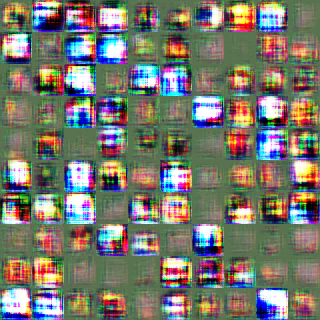

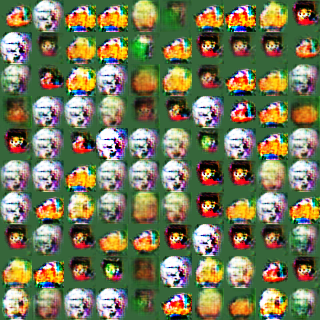

The first image is the output at epoch 200 and the second image is the output at epoch 19600. The first image is blurry and contains no notable information. It just seems like a random organization of pixels. However, in the second image, you could see faces of some emojis. Although other emojis are unclear, there are patterns in their colours, which means that GAN is improving.

## Question 2

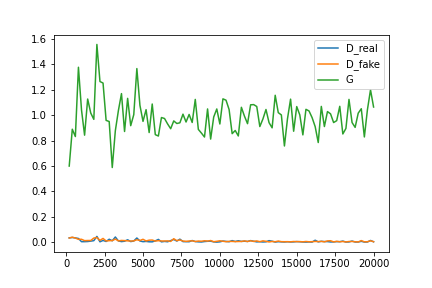

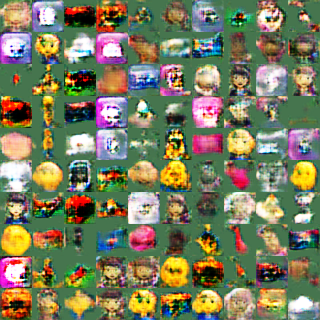

Becase Least Squares uses least squares loss, penalizing the samples lying a long way to the decision boundary can generate more gradients when updating the generator. This resolves the vanishing gradient problem. From the loss plot, Least Square GAN stabliizes trainig as the loss of G fluctuates less. Additionally, the outputs from the code shows that there are more distinctions between every emoji, which means that LS GAN is more stable and performs better than GAN.